<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Create a Helper Function to Plot Graphs:

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.4.1


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [ ]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-02-21 21:46:40.803352: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
I0221 21:46:43.977548 140005830662016 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
2021-02-21 21:46:43.992844: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-02-21 21:46:44.059602: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-02-21 21:46:44.099552: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
I0221 21:46:44.142564 140005830662016 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GC

###  Exploratory Analysis AG News Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [ ]:
info

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [ ]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories) 

In [ ]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories

In [ ]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

We will use the tf.keras.layers.experimental.preprocessing.TextVectorization layer to transform each news article into a "list" of non-negative integers representing the tokens in the news article.

For the purpose of training our models each such "encoding" will have a fixed length corresponding to the news article(s) with the most tokens. Shorter articles will be right-padded with zeros in the encoding. Also to speed up the training process, we will set max_tokens = 1000 so that words not in the vabulary set of top 1000 most common tokes are encoded as 1. But first we set max_tokens = None (which is the default value) in order to get the vocabulary size of the corpus.


In [ ]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7f028abfa620>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f028abfa620>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f028abfa620>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 29s, sys: 26.1 s, total: 1min 55s
Wall time: 1min 5s


In [ ]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


There are 95976 vocabulary words in the corpus.

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U150')

Let's use how the encoding works on a sample string all of whose words are in the vocabulary of the corpus

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is in the vocabulary.
"ran" is in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [ ]:
encoder(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([   2, 5958, 1287,   29,    3,  232, 1414,   14,   19, 2548,   18,
          2, 2435,    8,    2,  999])>

Let us get the total number of words in the corpus and the sizes of the news articles

In [ ]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 5min 49s, sys: 4.38 s, total: 5min 53s
Wall time: 5min 34s


In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


Text(0, 0.5, 'Number of AG News Articles')

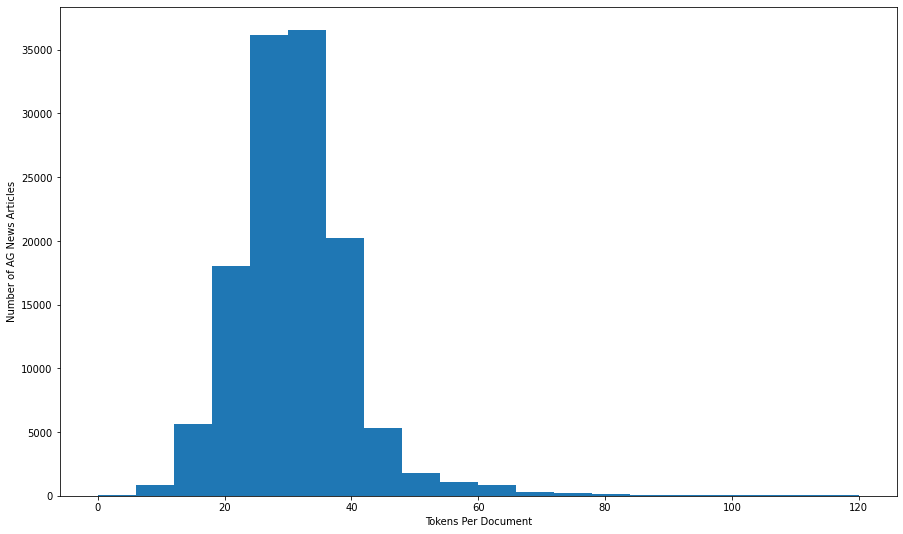

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")

Encode the news articles using the top 1000 most common words in the corpus

In [ ]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7f0b1d697ae8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f0b1d697ae8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f0b1d697ae8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 40s, sys: 28.5 s, total: 2min 8s
Wall time: 1min 11s


The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In particular, 0 is use for padding, 1 for the unknown words, 2 for the common word, i.e. 'the', etc. Let us look at the same example we encoded previously using the encoder for all the vocabulary words. Note that there are now five 1's denoting words that are not in the top 1000 in frequency.

We encode the same example as before using the new encoder. Note that there are now 5 out of vocabulary words.

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2, 999])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


We want to determine the number of non-vocabulary words in each news articles (denoted by 1s in the encoding)

In [ ]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 6min 47s, sys: 8.81 s, total: 6min 56s
Wall time: 6min 36s


In [ ]:
print(f"There are {len(corpus1000)} words in the corpus of {len(doc1000_sizes)} news articles.")
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.




Note below that most of the news articles consists of at least 60% (top 1000) vocabulary words (with only 22 out for 127,600 news articles containing no top 1000 vacabulary words)

In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True) 

(array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  95,  97, 100]),
 array([  12,    5,   20,   29,   49,   71,  120,  137,  172,  274,  486,
         368,  682,  777,  828, 1346, 1376, 2123, 1610, 2863, 2687, 3018,
        3957, 3315, 4605, 3934, 4148, 5737, 4954, 5072, 6123, 6165, 3255,
        5095, 4596, 3438, 5880, 4205, 3109, 4063, 3555, 3030, 2904, 2294,
        1967, 1716, 2174,  368, 2486,  234, 1246,  747,  573,  547,  520,
         441,  348,  217,  250,  135,  234,   49,  131,  101,   11,  135,
          40,  

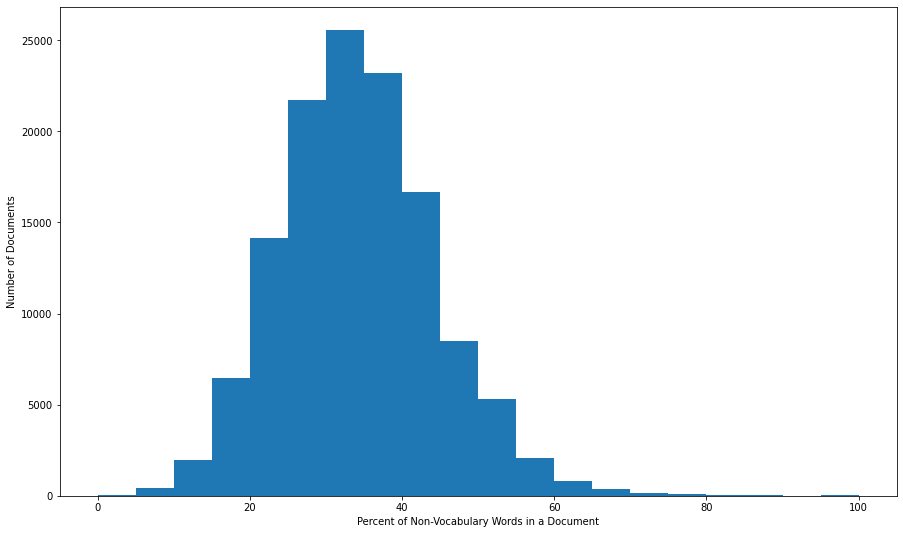

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {len(corpus1000)} words in the corpus with {useless} documents not containing any of the top {len(vocab_1000)} vocabulary words.")
print(f"There are {count1000} top {len(vocab_1000)} vocabulary words in the corpus.")

There are 3909695 words in the corpus with 22 documents not containing any of the top 1000 vocabulary words.
There are 2602670 top 1000 vocabulary words in the corpus.


### Preprocessing Data Create Input Pipeline

In [ ]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-02-21 21:47:21.302835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
I0221 21:47:24.404196 139772104513408 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0221 21:47:24.405736 139772104513408 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0221 21:47:24.407456 139772104513408 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0221 21:47:24.407842 139772104513408 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is provided by the 

In [ ]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [ ]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label Encoded Classification(text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


In [ ]:
for x in train_dataset.take(1):
  print(x)

(<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'Israeli PM Ariel Sharon appears to have eased his preconditions for resuming talks with the Palestinians.',
       b'SiliconValley.com - SBC announced consumer tests of its Internet phone service Tuesday in Los Angeles and three other major cities and said it will offer the low-cost, feature-laden plans to all broadband customers in its 13-state territory including California early next year.',
       b'World News: Islamabad, Oct 30 : Pakistan President Pervez Musharraf Saturday said a solution to the dragging Kashmir dispute could be found only if India and Pakistan agreed to move beyond their stated positions on the issue.',
       b'Tom Brady threw two touchdown passes and Adam Vinatieri kicked five field goals to lead the New England Patriots past the Buffalo Bills, 29-6, Sunday night.',
       b'Iraqi interim Prime Minister Ayad Allawi said Sunday that he was getting closer to authorizing major military action against insurge

#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'CHICAGO - Illinois Gov. Rod Blagojevich yesterday proposed the state ban the sale and rental of violent and sexually explicit video games for children under 18, a restriction that has failed so far elsewhere in the country.'
 b'Ingram Micro is all set to acquire Tech Pacific, in a move that will significantly impact the Indian IT distribution and channels sector.'
 b'At least two Iraqis were killed in clashes today between US troops and insurgents in the restive city of Ramadi, as a militant group claimed it had executed 11 members of the Iraqi National Guard.']

labels:  [3 2 0]
texts:  [b'NEW YORK Sunday afternoon NFL games are staying on CBS and Fox. The league and the networks have agreed to six-year contract extensions in deals worth a combined eight (b) billion dollars.'
 b'Australia win the toss and bat first in the tri-series final against Pakistan.'
 b' TOKYO (Reuters) - The Japanese navy was mobilized on  Wednesday for the first time in five years after an  unident

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'LABOUR officials yesterday dismissed reports that Tony Blair is contemplating a snap general election in February and insisted that May remained the most likely time for the poll.'
 b'The worst attack was a car bomb explosion outside a police training center in Baghdad. At least 47 people, mostly new recruits, were killed and more than 100 wounded.'
 b'FURIOUS Harry Redknapp and Portsmouth chairman Milan Mandaric joined forces today in an astonishing bid to end slurs over Pompey #39;s transfer policy.']

labels:  ['World', 'World', 'Sports']

texts:  [b'Telstra Corp., Australia #39;s biggest phone company, will next year begin cutting the number of workers among its 4,500 middle managers, spokesman Michael Grealy said.'
 b'London has unveiled its detailed plans to stage the 2012 Olympics, promising a Games of excellence without extravagance. Bid chief Sebastian Coe said on Friday the city would '
 b"AP - Cambodia's newly selected king returned from China on Wednesday to take

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 21,  55,   1,  25,   1,   5, 433,  70, 240,  18, 365,  69,   1,
         54,  76,   2,  81, 136,  43, 805,   6,  15, 420,   5, 153, 669,
         67, 199,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  1,   1,  33, 812,   1,   4, 635, 402, 141,  34,   1, 115,  53,
          1,   1,   7,   1, 774,   8, 870,   1,   1,   1, 402,   1,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  1,   1,  50,  41, 167,   4,   2, 823,   5, 540,   1,   1,   1,
        130,   2, 640, 365, 424,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'NEW YORK (CNN/Money) - US stockpiles of crude oil rose by 1.1 million barrels last week, the government reported Wednesday, coming in at half of what analysts had expected.'
Round-trip:  new york [UNK] us [UNK] of crude oil rose by 11 million [UNK] last week the government reported wednesday coming in at half of what analysts had expected                 

Original:  b"Baby Bells are spending billions to sell video service over broadband. Can they crack cable and satellite's hold on TV viewers?&lt;br /&gt;\\  Image: Video via broadband"
Round-trip:  [UNK] [UNK] are spending [UNK] to sell video service over [UNK] can they [UNK] [UNK] and [UNK] hold on tv [UNK] [UNK] [UNK] video [UNK] [UNK]                   

Original:  b'PRAGUE -- Add one more country to the list of those decrying intelligence failures before the Sept. 11 attacks.'
Round-trip:  [UNK] [UNK] one more country to the list of those [UNK] [UNK] [UNK] before the sept 11 attacks                           



## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [ ]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
history = model.fit(train_dataset
                    ,epochs = 10
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
                                ]
                    )

Epoch 1/10
1782/1782 [==============================] - 155s 87ms/step - loss: 0.3749 - accuracy: 0.8636 - val_loss: 0.3820 - val_accuracy: 0.8635
Epoch 2/10
1782/1782 [==============================] - 156s 87ms/step - loss: 0.3715 - accuracy: 0.8638 - val_loss: 0.3890 - val_accuracy: 0.8583
Epoch 3/10
1782/1782 [==============================] - 163s 92ms/step - loss: 0.3689 - accuracy: 0.8649 - val_loss: 0.3756 - val_accuracy: 0.8663
Epoch 4/10
1782/1782 [==============================] - 166s 93ms/step - loss: 0.3656 - accuracy: 0.8656 - val_loss: 0.3743 - val_accuracy: 0.8663
Epoch 5/10
1782/1782 [==============================] - 166s 93ms/step - loss: 0.3621 - accuracy: 0.8676 - val_loss: 0.3737 - val_accuracy: 0.8647


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 3s 29ms/step - loss: 0.3950 - accuracy: 0.8559
Test Loss: 0.395048588514328
Test Accuracy: 0.8559210300445557


## Plotting Performance Metrics - Single Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
0,0.374852,0.863570,0.382021,0.863500
1,0.371542,0.863825,0.388982,0.858333
2,0.368905,0.864930,0.375599,0.866333
3,0.365591,0.865649,0.374270,0.866333
4,0.362146,0.867553,0.373735,0.864667


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

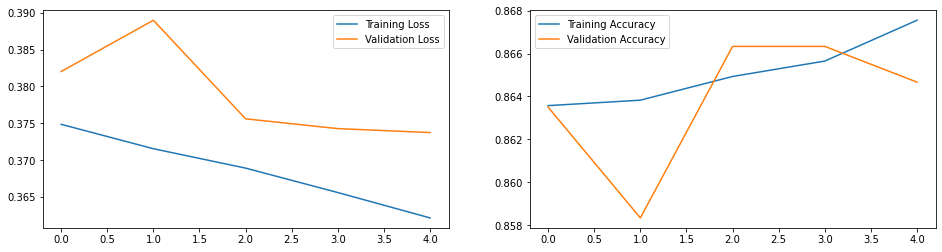

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 138,564
Trainable params: 138,564
Non-trainable params: 0
_________________________________________________________________


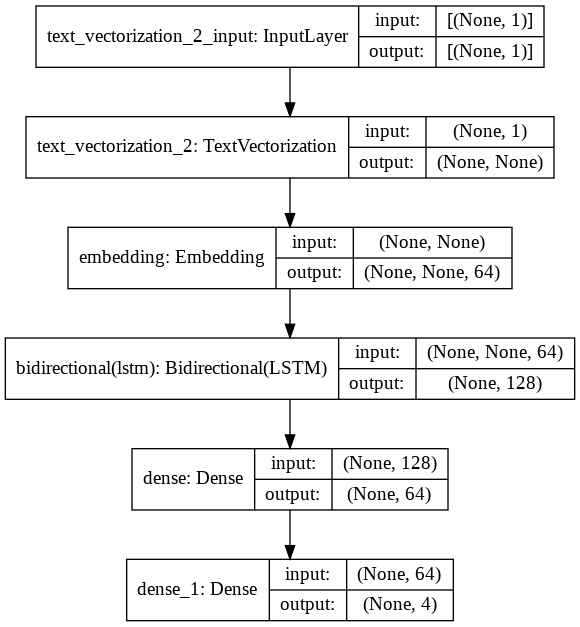

In [ ]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                                ]
                    )

Epoch 1/200
1782/1782 [==============================] - 294s 155ms/step - loss: 0.6608 - accuracy: 0.7376 - val_loss: 0.4542 - val_accuracy: 0.8448
Epoch 2/200
1782/1782 [==============================] - 275s 154ms/step - loss: 0.4313 - accuracy: 0.8497 - val_loss: 0.4472 - val_accuracy: 0.8370
Epoch 3/200
1782/1782 [==============================] - 273s 153ms/step - loss: 0.4076 - accuracy: 0.8559 - val_loss: 0.4019 - val_accuracy: 0.8562
Epoch 4/200
1782/1782 [==============================] - 271s 152ms/step - loss: 0.3909 - accuracy: 0.8625 - val_loss: 0.4058 - val_accuracy: 0.8552
Epoch 5/200
1782/1782 [==============================] - 273s 153ms/step - loss: 0.3698 - accuracy: 0.8678 - val_loss: 0.3725 - val_accuracy: 0.8646
Epoch 6/200
1782/1782 [==============================] - 269s 151ms/step - loss: 0.3527 - accuracy: 0.8730 - val_loss: 0.3695 - val_accuracy: 0.8656
Epoch 7/200
1782/1782 [==============================] - 269s 151ms/step - loss: 0.3354 - accuracy: 0.8783

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 3s 24ms/step - loss: 0.3950 - accuracy: 0.8559
Test Loss: 0.395048588514328
Test Accuracy: 0.8559210300445557


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail()

,loss,accuracy,val_loss,val_accuracy
5,0.351727,0.873798,0.369507,0.865625
6,0.335882,0.878342,0.338529,0.870833
7,0.322344,0.883342,0.375616,0.876042
8,0.308732,0.887351,0.345838,0.871354
9,0.293879,0.892368,0.390055,0.866146


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

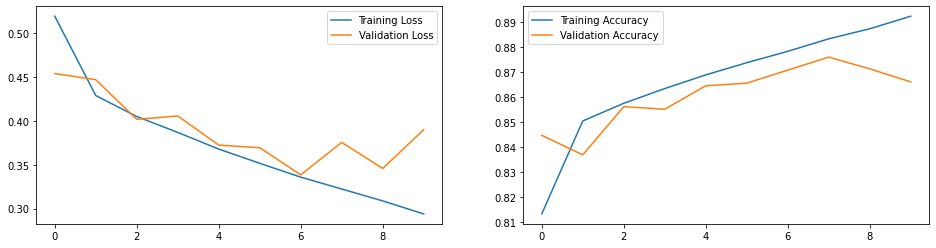

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

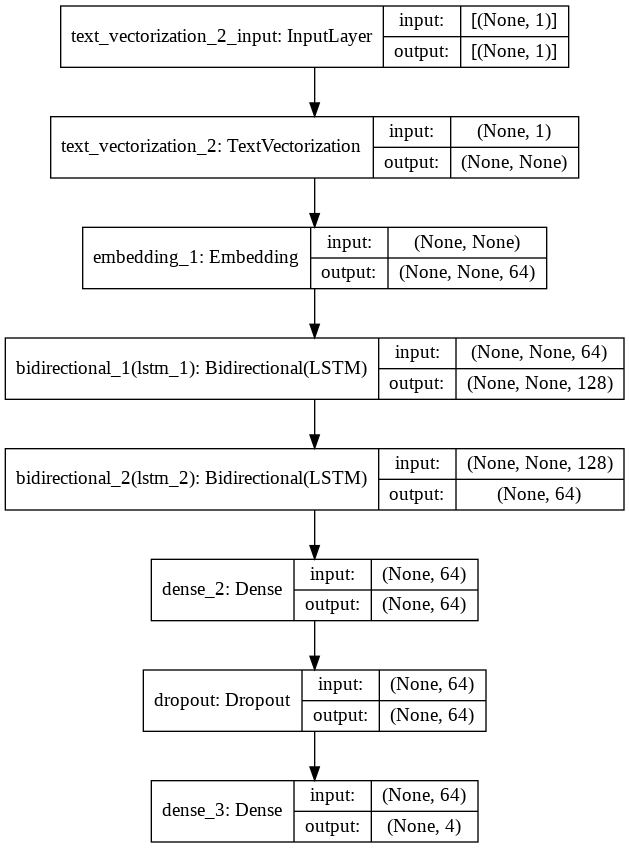

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).


In [ ]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model.tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model.tf/assets


In [ ]:
model2.save('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model2.tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model2.tf/assets


## Change vocab to 500

In [ ]:
VOCAB_SIZE=500
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

500

In [ ]:
model3 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model3.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_dataset
                    ,epochs=10
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                                ]
                    )

Epoch 1/10
1782/1782 [==============================] - 278s 147ms/step - loss: 0.7409 - accuracy: 0.6980 - val_loss: 0.4748 - val_accuracy: 0.8401
Epoch 2/10
1782/1782 [==============================] - 257s 144ms/step - loss: 0.5148 - accuracy: 0.8155 - val_loss: 0.4955 - val_accuracy: 0.8146
Epoch 3/10
1782/1782 [==============================] - 262s 147ms/step - loss: 0.4951 - accuracy: 0.8208 - val_loss: 0.4281 - val_accuracy: 0.8479
Epoch 4/10
1782/1782 [==============================] - 259s 145ms/step - loss: 0.4781 - accuracy: 0.8275 - val_loss: 0.4565 - val_accuracy: 0.8292
Epoch 5/10
1782/1782 [==============================] - 257s 144ms/step - loss: 0.4625 - accuracy: 0.8309 - val_loss: 0.4417 - val_accuracy: 0.8292


In [ ]:
model3.save('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model3.tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model3.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model3.tf/assets


In [ ]:
model3=keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model3.tf')

In [ ]:
test_loss, test_acc = model3.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 8s 33ms/step - loss: 0.4576 - accuracy: 0.8305
Test Loss: 0.4575806260108948
Test Accuracy: 0.8305262923240662


## Change Vocab to 2000

In [ ]:
VOCAB_SIZE=2000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

2000

In [ ]:
model4 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model4.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_dataset
                    ,epochs=10
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                                ]
                    )

Epoch 1/10
1782/1782 [==============================] - 280s 148ms/step - loss: 0.5977 - accuracy: 0.7685 - val_loss: 0.3612 - val_accuracy: 0.8792
Epoch 2/10
1782/1782 [==============================] - 262s 147ms/step - loss: 0.3618 - accuracy: 0.8779 - val_loss: 0.3534 - val_accuracy: 0.8813
Epoch 3/10
1782/1782 [==============================] - 259s 146ms/step - loss: 0.3353 - accuracy: 0.8842 - val_loss: 0.3282 - val_accuracy: 0.8724
Epoch 4/10
1782/1782 [==============================] - 263s 147ms/step - loss: 0.3122 - accuracy: 0.8902 - val_loss: 0.3547 - val_accuracy: 0.8734


In [ ]:
model4.save('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model4.tf')

NameError: ignored

In [ ]:
model4 = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model4.tf')

In [ ]:
test_loss, test_acc = model4.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 9s 34ms/step - loss: 0.3439 - accuracy: 0.8822
Test Loss: 0.34393635392189026
Test Accuracy: 0.8822368383407593


In [ ]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

## Remove Stop Words

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize

def remove_stopwords(data):
  stop_words = set(stopwords.words('english'))
  data_set=[] 
  print(len(data)) 
  for examples, labels in data.take(114000):
      #print(len(examples))
      labels_ls=[]
      for label in labels:
        labels_ls.append(label.numpy())
      for example in examples:
          filtered_data=[]
          example=example.numpy().decode("utf-8")
          word_tokens = word_tokenize(example) 
          for w in word_tokens:
              w=w.lower()
              if w not in stop_words:  
                filtered_data.append(w)
          filtered_data=' '.join(filtered_data)
          filtered_data=filtered_data.encode("utf-8")
          data_set.append(filtered_data)
      #labels_ls=np.array(labels_ls)
      data_set_np=np.array(data_set)
      #data_set=np.concatenate(data_set)
      #data_set=[list(a) for a in zip(removed_train,labels_ls)]
      #data_set=np.concatenate((data_set, labels_ls))
  return data_set_np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
removed_train=remove_stopwords(train_dataset)

1782


In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(removed_train)

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '39', 'said', 's', 'new', 'us', 'reuters', 'quot',
       'ap', 'two', 'gt', 'lt', 'first', 'monday', 'wednesday', 'company',
       'tuesday', 'world', 'thursday'], dtype='<U34')

In [ ]:
num_classes = 4
model5 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model5.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_dataset
                    ,epochs=10
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    #,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    #            ]
                    )

Epoch 1/10
1782/1782 [==============================] - 244s 128ms/step - loss: 0.6655 - accuracy: 0.7320 - val_loss: 0.4094 - val_accuracy: 0.8453
Epoch 2/10
1782/1782 [==============================] - 227s 128ms/step - loss: 0.4320 - accuracy: 0.8493 - val_loss: 0.4104 - val_accuracy: 0.8490
Epoch 3/10
1782/1782 [==============================] - 226s 127ms/step - loss: 0.4129 - accuracy: 0.8524 - val_loss: 0.3837 - val_accuracy: 0.8589
Epoch 4/10
1782/1782 [==============================] - 225s 126ms/step - loss: 0.3917 - accuracy: 0.8603 - val_loss: 0.3947 - val_accuracy: 0.8505
Epoch 5/10
1782/1782 [==============================] - 225s 126ms/step - loss: 0.3718 - accuracy: 0.8657 - val_loss: 0.3554 - val_accuracy: 0.8651
Epoch 6/10
1782/1782 [==============================] - 226s 127ms/step - loss: 0.3618 - accuracy: 0.8681 - val_loss: 0.3731 - val_accuracy: 0.8641
Epoch 7/10
1782/1782 [==============================] - 226s 127ms/step - loss: 0.3462 - accuracy: 0.8746 - val_

In [ ]:
model5.save('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model5.tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model5.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model5.tf/assets


In [ ]:
test_loss, test_acc = model5.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 5s 40ms/step - loss: 0.3897 - accuracy: 0.8653
Test Loss: 0.38968974351882935
Test Accuracy: 0.8652631640434265


## Change Sequence Length

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE,output_sequence_length=60)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
num_classes = 4
model6 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model6.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_dataset
                    ,epochs=10
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                                ]
                    )

Epoch 1/10
1782/1782 [==============================] - 233s 121ms/step - loss: 0.6654 - accuracy: 0.7333 - val_loss: 0.4275 - val_accuracy: 0.8516
Epoch 2/10
1782/1782 [==============================] - 224s 125ms/step - loss: 0.4330 - accuracy: 0.8504 - val_loss: 0.3803 - val_accuracy: 0.8698
Epoch 3/10
1782/1782 [==============================] - 234s 131ms/step - loss: 0.4086 - accuracy: 0.8561 - val_loss: 0.3883 - val_accuracy: 0.8594
Epoch 4/10
1782/1782 [==============================] - 231s 130ms/step - loss: 0.3904 - accuracy: 0.8601 - val_loss: 0.3977 - val_accuracy: 0.8589


In [ ]:
model6.save('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model6.tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model6.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model6.tf/assets


In [ ]:
test_loss, test_acc = model6.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 5s 39ms/step - loss: 0.3966 - accuracy: 0.8579
Test Loss: 0.3966323137283325
Test Accuracy: 0.8578947186470032


## RNN experiment

In [ ]:
num_classes = 4
model7 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model7.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history7 = model7.fit(train_dataset
                    ,epochs=10
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                                ]
                    )

Epoch 1/10
1782/1782 [==============================] - 67s 35ms/step - loss: 0.6889 - accuracy: 0.7123 - val_loss: 0.4339 - val_accuracy: 0.8432
Epoch 2/10
1782/1782 [==============================] - 64s 36ms/step - loss: 0.4149 - accuracy: 0.8508 - val_loss: 0.4584 - val_accuracy: 0.8344
Epoch 3/10
1782/1782 [==============================] - 64s 36ms/step - loss: 0.3855 - accuracy: 0.8585 - val_loss: 0.4180 - val_accuracy: 0.8500
Epoch 4/10
1782/1782 [==============================] - 64s 36ms/step - loss: 0.3586 - accuracy: 0.8688 - val_loss: 0.4086 - val_accuracy: 0.8589
Epoch 5/10
1782/1782 [==============================] - 64s 36ms/step - loss: 0.3350 - accuracy: 0.8766 - val_loss: 0.4265 - val_accuracy: 0.8557
Epoch 6/10
1782/1782 [==============================] - 65s 36ms/step - loss: 0.3119 - accuracy: 0.8844 - val_loss: 0.5015 - val_accuracy: 0.8167


In [ ]:
model7.save('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model7.tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model7.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model7.tf/assets


In [ ]:
#model7=keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model7.tf')

In [ ]:
model7.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_17 (TextV (None, 60)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 60, 64)            64000     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 260       
Total params: 89,028
Trainable params: 89,028
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_loss, test_acc = model7.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 9ms/step - loss: 0.5057 - accuracy: 0.8279
Test Loss: 0.5057162642478943
Test Accuracy: 0.8278947472572327


## LSTM Experiment

In [ ]:
num_classes = 4
model8 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.LSTM(64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model8.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history8 = model8.fit(train_dataset
                    ,epochs=10
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                                ]
                    )

Epoch 1/10
1782/1782 [==============================] - 98s 53ms/step - loss: 0.6950 - accuracy: 0.7174 - val_loss: 0.4391 - val_accuracy: 0.8385
Epoch 2/10
1782/1782 [==============================] - 95s 53ms/step - loss: 0.4470 - accuracy: 0.8455 - val_loss: 0.4071 - val_accuracy: 0.8510
Epoch 3/10
1782/1782 [==============================] - 97s 54ms/step - loss: 0.4256 - accuracy: 0.8524 - val_loss: 0.3932 - val_accuracy: 0.8547
Epoch 4/10
1782/1782 [==============================] - 97s 54ms/step - loss: 0.4085 - accuracy: 0.8568 - val_loss: 0.3879 - val_accuracy: 0.8635
Epoch 5/10
1782/1782 [==============================] - 100s 56ms/step - loss: 0.3913 - accuracy: 0.8601 - val_loss: 0.3911 - val_accuracy: 0.8661
Epoch 6/10
1782/1782 [==============================] - 101s 57ms/step - loss: 0.3762 - accuracy: 0.8643 - val_loss: 0.3831 - val_accuracy: 0.8609
Epoch 7/10
1782/1782 [==============================] - 105s 59ms/step - loss: 0.3596 - accuracy: 0.8703 - val_loss: 0.398

In [ ]:
model8.save('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model8.tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model8.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model8.tf/assets


In [ ]:
#model8=keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model8.tf')

In [ ]:
model8.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_17 (TextV (None, 60)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 60, 64)            64000     
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 260       
Total params: 101,444
Trainable params: 101,444
Non-trainable params: 0
________________________________________________

In [ ]:
test_loss, test_acc = model8.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 17ms/step - loss: 0.4034 - accuracy: 0.8546
Test Loss: 0.4033550024032593
Test Accuracy: 0.8546052575111389


## 1D CNN

In [ ]:
num_classes = 4
model9 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Conv1D(64,3, activation='relu')
                              ,tf.keras.layers.MaxPooling1D(2)
                              ,tf.keras.layers.Flatten()
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model9.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history9 = model9.fit(train_dataset
                    ,epochs=10
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                                ]
                    )

Epoch 1/10
1782/1782 [==============================] - 15s 8ms/step - loss: 0.7334 - accuracy: 0.6971 - val_loss: 0.3996 - val_accuracy: 0.8562
Epoch 2/10
1782/1782 [==============================] - 14s 8ms/step - loss: 0.4206 - accuracy: 0.8517 - val_loss: 0.3790 - val_accuracy: 0.8646
Epoch 3/10
1782/1782 [==============================] - 14s 8ms/step - loss: 0.3913 - accuracy: 0.8594 - val_loss: 0.3891 - val_accuracy: 0.8646
Epoch 4/10
1782/1782 [==============================] - 15s 8ms/step - loss: 0.3641 - accuracy: 0.8706 - val_loss: 0.3911 - val_accuracy: 0.8573


In [ ]:
model9.save('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model9.tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model9.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Assignment3/model9.tf/assets


In [ ]:
#model9=keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Assignment3/model9.tf')

In [ ]:
model9.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_17 (TextV (None, 60)                0         
_________________________________________________________________
embedding_41 (Embedding)     (None, 60, 64)            64000     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 58, 64)            12352     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 29, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1856)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 64)                118848    
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)              

In [ ]:
test_loss, test_acc = model9.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 4ms/step - loss: 0.4021 - accuracy: 0.8562
Test Loss: 0.40208014845848083
Test Accuracy: 0.856184184551239
